# Craft curves

In [1]:
import numpy as np
from math import cos, pi, sin
import pandas as pd

np.random.seed(42)

max_size = 500

K1 = [cos(2*pi/8*t) for t in range(max_size)]
K2 = []
for t in range(0, max_size, 8):
  K2 += [0, 2, 1, 2, 0, -2, -1, -2]
K2 = K2[:max_size]

K3 = [0.5+sin(2*pi/7*t) for t in range(max_size)]

K4 = []
for t in range(0, max_size, 5):
    K4 += [2, 1, 1, 1, 2]
K4 = K4[:max_size]


K5 = [K4[i]*K3[i] + K2[i] - K1[i] for i in range(max_size)]


# Check curves

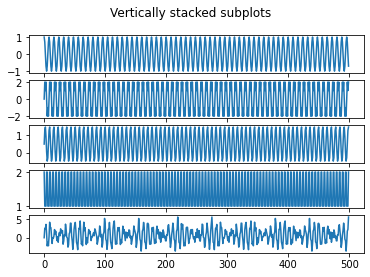

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, sharex=True)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(K1)
axs[1].plot(K2)
axs[2].plot(K3)
axs[3].plot(K4)
axs[4].plot(K5)

In [3]:
df = pd.DataFrame({'K1': K1, 'K2': K2, 'K3': K3, 'K4': K4, 'K5': K5}, columns=['K1', 'K2', 'K3', 'K4', 'K5'], dtype='float32')
df.shape

df.describe()

,K1,K2,K3,K4,K5
count,5.000000e+02,500.00000,500.000000,500.00000,500.000000
mean,2.000000e-03,0.01000,0.503514,1.40000,0.710646
std,7.078122e-01,1.50147,0.707893,0.49039,1.972463
min,-1.000000e+00,-2.00000,-0.474928,1.00000,-3.656963
25%,-7.071068e-01,-1.00000,-0.281831,1.00000,-0.867767
50%,3.964628e-16,0.00000,0.500000,1.00000,0.718168
75%,7.071068e-01,2.00000,1.281832,2.00000,2.226777
max,1.000000e+00,2.00000,1.474928,2.00000,5.656962


# Define problem

X lives on a weierd planet where males can be feconded only when the Y rate is above 4. Zorg has measured carefully 
all components in the atmosphere and he is looking at predicting the Y rate in 5 & 6 days from now because his 
girlfiriend is living far away.
At a data scientist our role is to help zorg !

We will choose time series of differents size (between 10 & 15) and want to forecast the Y rate.

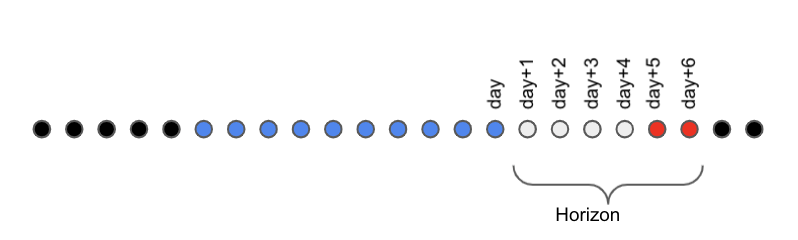

In [4]:
# Split our dataset in X_train, Xval & X_test

length = int(0.8*len(df))

horizon = 6

df_train = df.iloc[:length, :]
df_test = df.iloc[length:, :]

# Lest split X_train again

length = int(0.8*len(df_train))
df_val = df_train.iloc[length:, :]
df_train = df_train.iloc[:length, :]

print(df_train.shape, df_val.shape, df_test.shape)

(320, 5) (80, 5) (100, 5)


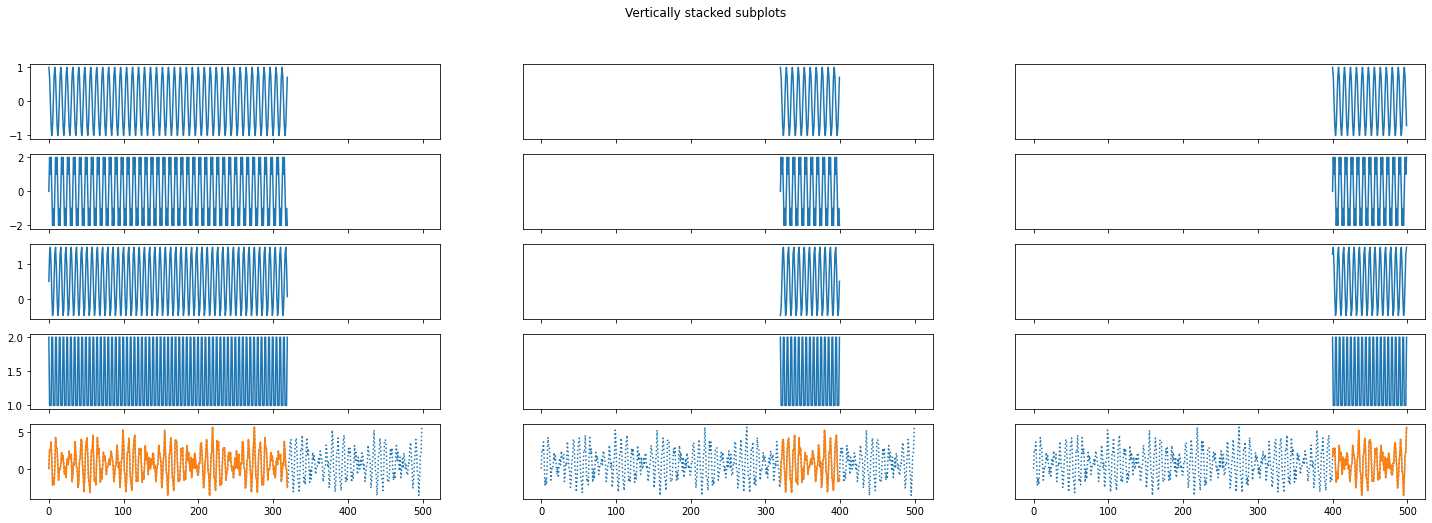

In [5]:
fig, axs = plt.subplots(nrows=5, ncols=3, sharex=True, figsize=(25, 8))
fig.suptitle('Vertically stacked subplots')
axs[0, 0].plot(df_train[['K1']])
axs[0, 1].plot(df_val[['K1']]); axs[0, 1].yaxis.set_visible(False)
axs[0, 2].plot(df_test[['K1']]); axs[0, 2].yaxis.set_visible(False)

axs[1, 0].plot(df_train[['K2']])
axs[1, 1].plot(df_val[['K2']]); axs[1, 1].yaxis.set_visible(False)
axs[1, 2].plot(df_test[['K2']]); axs[1, 2].yaxis.set_visible(False)

axs[2, 0].plot(df_train[['K3']])
axs[2, 1].plot(df_val[['K3']]); axs[2, 1].yaxis.set_visible(False)
axs[2, 2].plot(df_test[['K3']]); axs[2, 2].yaxis.set_visible(False)

axs[3, 0].plot(df_train[['K4']])
axs[3, 1].plot(df_val[['K4']]); axs[3, 1].yaxis.set_visible(False)
axs[3, 2].plot(df_test[['K4']]); axs[3, 2].yaxis.set_visible(False)

axs[4, 0].plot(df[['K5']], ls=':');
axs[4, 0].plot(df_train[['K5']])
axs[4, 1].plot(df[['K5']], ls=':');
axs[4, 1].plot(df_val[['K5']]); axs[4, 1].yaxis.set_visible(False)
axs[4, 2].plot(df[['K5']], ls=':');
axs[4, 2].plot(df_test[['K5']]); axs[4, 2].yaxis.set_visible(False)

# Now Let's define some sequences in each of these partitions

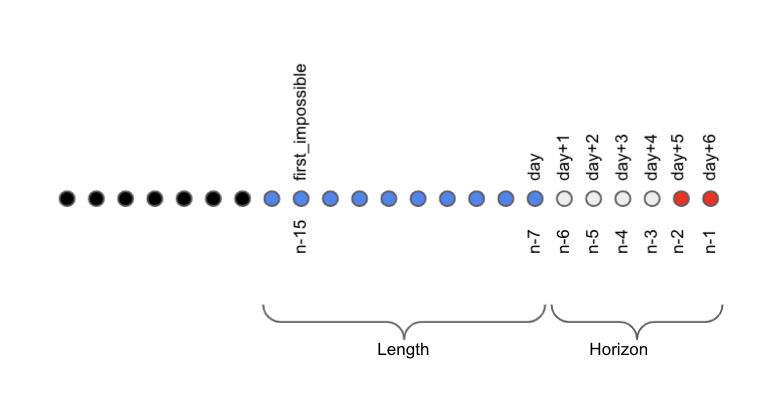

In [6]:
def get_subsample_sequence(df, length, horizon):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random.
    """
    
    first_impossible = df.shape[0] - length - horizon + 1
    
    random_start = np.random.randint(0, first_impossible)
    df_sample = df[random_start: random_start+length+horizon]
    
    return df_sample

def split_subsample_sequence(df, length, what_to_predict):
    """Return one single sample (Xi, yi) containing one sequence each of length `length`"""
    
    horizon = sorted(what_to_predict)[-1]
        
    df_subsample = get_subsample_sequence(df, length, horizon).copy()
    
    # Create X_sample
    X_sample = df_subsample.iloc[:length, :]
    
    # Create y_sample
    y_sample = df_subsample.iloc[[w+length-1 for w in what_to_predict], :]
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, sequence_lengths, what_to_predict):
    '''Return a dataset (X, y)'''
    X, y = [], []
    
    for length in sequence_lengths:
        xi, yi = split_subsample_sequence(df, length, what_to_predict)
        X.append(xi)
        y.append(yi)
        
    return X, np.array(y)

In [7]:
what_to_predict = [1, 2]

assert 0 not in what_to_predict

horizon = sorted(what_to_predict)[-1]

In [8]:
sample = get_subsample_sequence(df_train, 10, horizon)
sample

,K1,K2,K3,K4,K5
102,-4.899206e-15,-1.0,0.066116,1.0,-0.933884
103,7.071068e-01,-2.0,-0.474928,1.0,-3.182035
104,1.000000e+00,0.0,-0.281831,2.0,-1.563663
105,7.071068e-01,2.0,0.500000,2.0,2.292893
106,1.468957e-15,1.0,1.281832,1.0,2.281832
107,-7.071068e-01,2.0,1.474928,1.0,4.182034
108,-1.000000e+00,0.0,0.933884,1.0,1.933884
109,-7.071068e-01,-2.0,0.066116,2.0,-1.160661
110,1.961292e-15,-1.0,-0.474928,2.0,-1.949856
111,7.071068e-01,-2.0,-0.281831,1.0,-2.988938


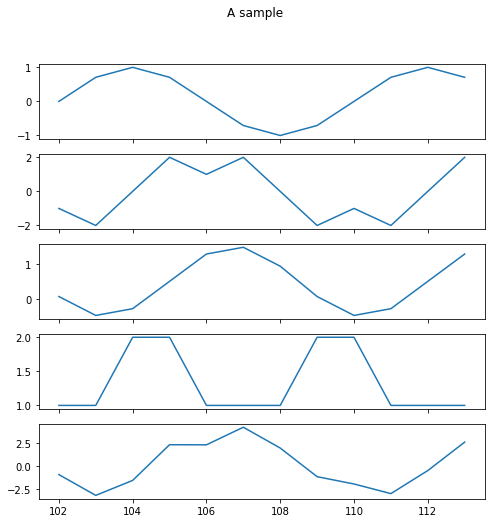

In [9]:
fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(8, 8))
fig.suptitle('A sample')

axs[0].plot(sample[['K1']])
axs[1].plot(sample[['K2']])
axs[2].plot(sample[['K3']])
axs[3].plot(sample[['K4']])
axs[4].plot(sample[['K5']])


In [10]:
min_seq_len = 10
max_seq_len = 15

padded_value = -5

sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=100)
X_train, y_train = get_X_y(df_train, sequence_lengths_train, what_to_predict)

sequence_lengths_val = np.random.randint(low=min_seq_len, high=max_seq_len, size=50)
X_val, y_val = get_X_y(df_val, sequence_lengths_val, what_to_predict)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=50)
X_test, y_test = get_X_y(df_test, sequence_lengths_test, what_to_predict)

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad_post = pad_sequences(X_train, value=padded_value, dtype=float, padding='post', maxlen=max_seq_len)
X_train_pad_pre  = pad_sequences(X_train, value=padded_value, dtype=float, padding='pre', maxlen=max_seq_len)

X_val_pad_post = pad_sequences(X_val, value=padded_value, dtype=float, padding='post', maxlen=max_seq_len)
X_val_pad_pre  = pad_sequences(X_val, value=padded_value, dtype=float, padding='pre', maxlen=max_seq_len)

X_test_pad_post = pad_sequences(X_test, value=padded_value, dtype='float32', padding='post', maxlen=max_seq_len)
X_test_pad_pre  = pad_sequences(X_test, value=padded_value, dtype='float32', padding='pre', maxlen=max_seq_len)

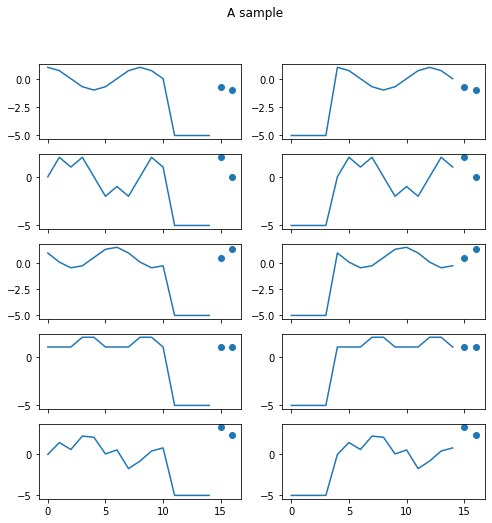

In [12]:
import random

fig, axs = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(8, 8))
fig.suptitle('A sample')

i = np.random.randint(len(X_train_pad_post))

the_range = [x+len(X_train_pad_post[i])-1 for x in what_to_predict]

axs[0, 0].plot(X_train_pad_post[i][:, 0])
axs[0, 0].scatter(the_range, y_train[i][:, 0])

axs[1, 0].plot(X_train_pad_post[i][:, 1])
axs[1, 0].scatter(the_range, y_train[i][:, 1])

axs[2, 0].plot(X_train_pad_post[i][:, 2])
axs[2, 0].scatter(the_range, y_train[i][:, 2])

axs[3, 0].plot(X_train_pad_post[i][:, 3])
axs[3, 0].scatter(the_range, y_train[i][:, 3])

axs[4, 0].plot(X_train_pad_post[i][:, 4])
axs[4, 0].scatter(the_range, y_train[i][:, 4])

axs[0, 1].plot(X_train_pad_pre[i][:, 0])
axs[0, 1].scatter(the_range, y_train[i][:, 0])

axs[1, 1].plot(X_train_pad_pre[i][:, 1])
axs[1, 1].scatter(the_range, y_train[i][:, 1])

axs[2, 1].plot(X_train_pad_pre[i][:, 2])
axs[2, 1].scatter(the_range, y_train[i][:, 2])

axs[3, 1].plot(X_train_pad_pre[i][:, 3])
axs[3, 1].scatter(the_range, y_train[i][:, 3])

axs[4, 1].plot(X_train_pad_pre[i][:, 4])
axs[4, 1].scatter(the_range, y_train[i][:, 4])

# Create an LSTM model

## Using xxx API

In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

def init_model(mask_value=-1000):
    
    model = models.Sequential()
    model.add(layers.Masking(mask_value=mask_value, input_shape=X_train_pad_pre.shape[1:]))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(y_train.shape[1], activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=RMSprop(), 
                  metrics=['mae'])
    
    return model

init_model().summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_5 (Masking)          (None, 15, 5)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 22        
Total params: 2,312
Trainable params: 2,312
Non-trainable params: 0
_________________________________________________________________


## Using functionnal API

In [ ]:
def init_model(mask_value=-1000):
    input_layer = layers.Input()
    lstm_hidden_layer_1 = layers.LSTM(10, stateful=True, return_sequences=True)(input_layer)
    lstm_hidden_layer_2 = layers.LSTM(10, stateful=True, return_sequences=True)(lstm_hidden_layer_1)
    output

input_1 = Input(batch_shape=(batch_size,timesteps,16))
#each layer is the input of the next layer
lstm_hidden_layer_1 = LSTM(10, stateful=True, return_sequences=True)(input_1)
lstm_hidden_layer_2 = LSTM(10, stateful=True, return_sequences=True)(lstm_hidden_layer_1)

In [14]:
print(X_train_pad_pre.shape, np.array(y_train).shape)
print(X_val_pad_pre.shape, np.array(y_val).shape)
print(y_train.shape[1])

(100, 15, 5) (100, 2, 5)
(50, 15, 5) (50, 2, 5)
2


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

model = init_model(mask_value=padded_value)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history = model.fit(X_train_pad_pre, np.array(y_train),
            validation_data=(X_val_pad_pre, np.array(y_val)),
            epochs=1000, 
            batch_size=16,
            callbacks=[es], verbose=0)

ValueError: in user code:

    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:862 train_function  *
        return step_function(self, iterator)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:852 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:845 run_step  **
        outputs = model.train_step(data)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:803 train_step
        loss = self.compiled_loss(
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1218 mean_squared_error
        return backend.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:10514 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /Users/alleon_g/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 2 and 5 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_1/dense_3/BiasAdd, IteratorGetNext:1)' with input shapes: [?,2], [?,2,5].
